In [1]:
import matplotlib.pyplot as plt 
import numpy as np

from tqdm import tqdm
import time

import agent
import integrate
import kalman_filter

In [2]:
# Define IMU refresh rate and corresponding wait time
imu_rate  = 60
imu_per   = 1 / imu_rate

# Define GNSS refresh rate and corresponding wait time
gnss_rate = 5
gnss_per  = 1 / gnss_rate

# Time for which to save results 
save_time = 100

# List length required for saving data
imu_len   = save_time * imu_rate
gnss_len  = save_time * gnss_rate

imu_std_dev_a     = 0.1
imu_std_dev_g     = 0
gnss_std_dev_geo  = 3e-5
gnss_std_dev_xy   = (np.pi * gnss_std_dev_geo / 180) * 6.357e6

print("GNSS std deviation : %.3fm"%gnss_std_dev_xy)

GNSS std deviation : 3.329m


In [3]:
# Create agent
a = agent.agent()
# a.client.reload_world()

In [4]:
# Spawn vehicle and sensors
a.spawn_vehicle()

 Vehicle model : toyota prius
 Spawning vehicle at location : 174, 9, 0 (random generation)


In [5]:
# Reset data memory for sensors
imu_list  = []
gnss_list = []
real_pos  = []

def imu_listener(data):
    
    if(len(imu_list) < imu_len):
        accel = data.accelerometer
        gyro  = data.gyroscope
        
        imu_list.append(((accel.x, accel.y, accel.z), (gyro.x, gyro.y, gyro.z), data.timestamp))

def gnss_listener(data):
    if(len(gnss_list) < gnss_len):
        x, y, z = a.gnss_to_xyz(data)
        rpos  = data.transform.location

        gnss_list.append(((x, y, z), data.timestamp))
        real_pos.append(((rpos.x, rpos.y, rpos.z), data.timestamp))


# Spawn sensors and set autopilot
a.spawn_imu(imu_per, imu_std_dev_a, imu_std_dev_g)
a.imu_reg_callback(imu_listener)
a.spawn_gnss(gnss_per, gnss_std_dev_geo)
a.gnss_reg_callback(gnss_listener)

a.vehicle.set_autopilot(True)

In [6]:
init_vel    = a.vehicle.get_velocity()
init_loc    = a.vehicle.get_location()
init_rot    = a.vehicle.get_transform().rotation
timestamp   = a.world.get_snapshot().timestamp.elapsed_seconds

init_state = np.asarray([init_loc.x, init_loc.y, init_rot.yaw * np.pi /180, init_vel.x, init_vel.y]).reshape(5,1)
int_obj = integrate.imu_integrate(init_state, timestamp)

int_rvel_list  = []
int_rpos_list  = []
int_ryaw_list  = []

def imu_int_listener(data):
    if(len(int_rvel_list) < imu_len):
        rvel    = a.vehicle.get_velocity()
        rloc    = a.vehicle.get_location()
        rrot    = a.vehicle.get_transform().rotation
        timestamp   = data.timestamp

        int_rvel_list.append(((rvel.x, rvel.y), timestamp))
        int_rpos_list.append(((rloc.x, rloc.y), timestamp))
        int_ryaw_list.append((rrot.yaw * np.pi / 180, timestamp))

        yaw_vel = data.gyroscope.z
        accel_x = data.accelerometer.x
        accel_y = data.accelerometer.y

        int_obj.update(np.asarray([accel_x, accel_y, yaw_vel]).reshape(3,1), timestamp)

a.imu_reg_callback(imu_int_listener)

In [7]:
init_vel    = a.vehicle.get_velocity()
init_loc    = a.vehicle.get_location()
init_rot    = a.vehicle.get_transform().rotation
timestamp   = a.world.get_snapshot().timestamp.elapsed_seconds

imu_var_a   = 0.1
imu_var_g   = 0
gnss_var    = 2

init_state = np.asarray([init_loc.x, init_loc.y, init_rot.yaw * np.pi /180, init_vel.x, init_vel.y]).reshape(5,1)
kal_obj = kalman_filter.kalman_filter(init_state, timestamp, imu_var_a, imu_var_g, gnss_var)

kal_rvel_list  = []
kal_rpos_list  = []
kal_ryaw_list  = []
kal_gnss_list  = []
kal_gact_list  = []

def imu_kal_listener(data):
    if(len(kal_rvel_list) < imu_len):
        rvel    = a.vehicle.get_velocity()
        rloc    = a.vehicle.get_location()
        rrot    = a.vehicle.get_transform().rotation
        timestamp   = data.timestamp

        kal_rvel_list.append(((rvel.x, rvel.y), timestamp))
        kal_rpos_list.append(((rloc.x, rloc.y), timestamp))
        kal_ryaw_list.append((rrot.yaw * np.pi / 180, timestamp))

        yaw_vel = data.gyroscope.z
        accel_x = data.accelerometer.x
        accel_y = data.accelerometer.y
        
        kal_obj.update(np.asarray([accel_x, accel_y, yaw_vel]).reshape(3,1), timestamp)
        
def gnss_kal_listener(data):
    if(len(kal_rvel_list) < imu_len):
        rloc    = a.vehicle.get_location()
        timestamp   = data.timestamp
        
        x, y, z = a.gnss_to_xyz(data)    
              
        kal_gnss_list.append(((x, y), timestamp))
        kal_gact_list.append(((rloc.x, rloc.y), timestamp))
        
        kal_obj.measure(np.asarray([x, y]).reshape(2,1), timestamp)

a.imu_reg_callback(imu_kal_listener)
a.gnss_reg_callback(gnss_kal_listener)

## Display outputs


499 of 500


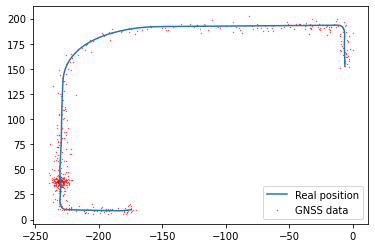

In [24]:
print("%d of %d"%(len(gnss_list), gnss_len))

rpos_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_rpos_list])
gnss_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_gnss_list])

plt.scatter(-gnss_xy[:,0], gnss_xy[:,1], 0.1, label="GNSS data", color='red')
plt.plot(-rpos_xy[:,0], rpos_xy[:,1], label="Real position")
plt.legend()
plt.show()

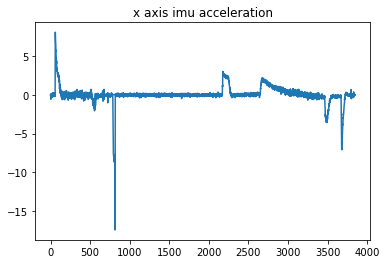

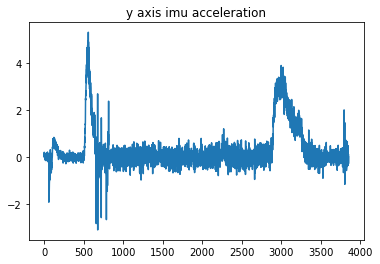

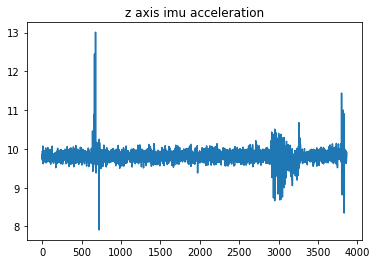

In [16]:
plt.plot([x[0][0] for x in imu_list])
plt.title('x axis imu acceleration')
plt.show()
plt.plot([x[0][1] for x in imu_list])
plt.title('y axis imu acceleration')
plt.show()
plt.plot([x[0][2] for x in imu_list])
plt.title('z axis imu acceleration')
plt.show()

Velocity with IMU integration. Samples received : 6000 of 6000


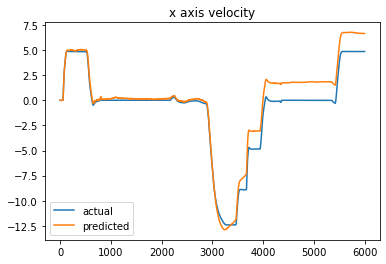

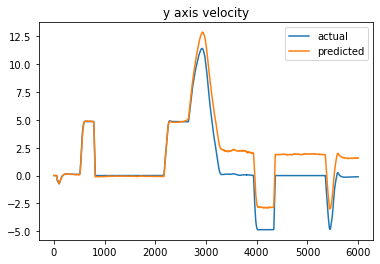

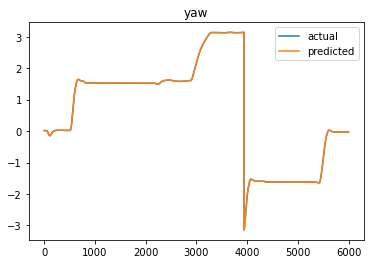

In [47]:
print("Velocity with IMU integration. Samples received : %d of %d"%(len(int_rvel_list), imu_len))

plt.plot([x[0][0] for x in int_rvel_list], label='actual')
plt.plot([x[0][3,0] for x in int_obj.states], label='predicted')
plt.title('x axis velocity')
plt.legend()
plt.show()

plt.plot([x[0][1] for x in int_rvel_list], label='actual')
plt.plot([x[0][4,0] for x in int_obj.states], label='predicted')
plt.title('y axis velocity')
plt.legend()
plt.show()

plt.plot([x[0] for x in int_ryaw_list], label='actual')
plt.plot([x[0][2,0] for x in int_obj.states], label='predicted')
plt.title('yaw')
plt.legend()
plt.show()

Position estimate with IMU integration. Samples received : 6000 of 6000


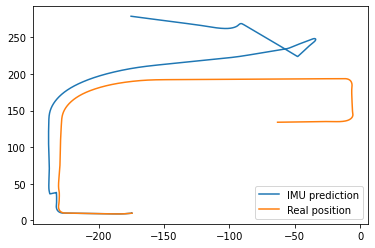

Time : 2218.15 to 2359.22
Time : 2218.15 to 2359.22


In [49]:
print("Position estimate with IMU integration. Samples received : %d of %d"%(len(int_rvel_list), imu_len))

rpos_xy = np.asarray([(x[0][0], x[0][1]) for x in int_rpos_list])
gnss_xy = np.asarray([(x[0][0], x[0][1]) for x in int_obj.states])

plt.plot(-gnss_xy[:,0], gnss_xy[:,1], label="IMU prediction")
plt.plot(-rpos_xy[:,0], rpos_xy[:,1], label="Real position")
plt.legend()
plt.show()

print("Time : %.2f to %.2f"%(int_rpos_list[0][1], int_rpos_list[-1][1]))
print("Time : %.2f to %.2f"%(int_obj.states[0][1], int_obj.states[-1][1]))

Velocity with Kalman filter. Samples received : 6000 of 6000


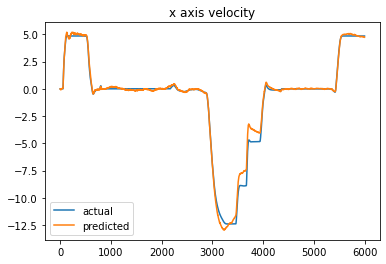

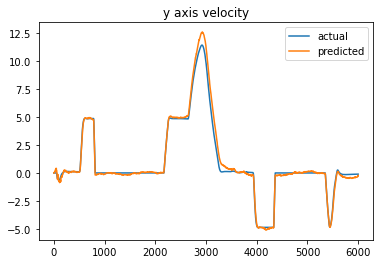

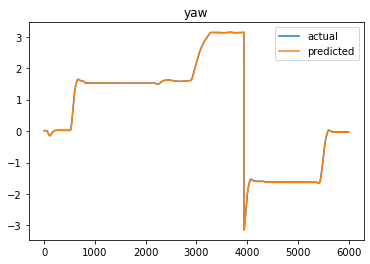

In [50]:
print("Velocity with Kalman filter. Samples received : %d of %d"%(len(int_rvel_list), imu_len))

plt.plot([x[0][0] for x in kal_rvel_list], label='actual')
plt.plot([x[0][3,0] for x in kal_obj.states if not x[2]], label='predicted')
plt.title('x axis velocity')
plt.legend()
plt.show()

plt.plot([x[0][1] for x in kal_rvel_list], label='actual')
plt.plot([x[0][4,0] for x in kal_obj.states if not x[2]], label='predicted')
plt.title('y axis velocity')
plt.legend()
plt.show()

plt.plot([x[0] for x in kal_ryaw_list], label='actual')
plt.plot([x[0][2,0] for x in kal_obj.states if not x[2]], label='predicted')
plt.title('yaw')
plt.legend()
plt.show()

Position estimate with kalman filter. Samples received : 6000 of 6000


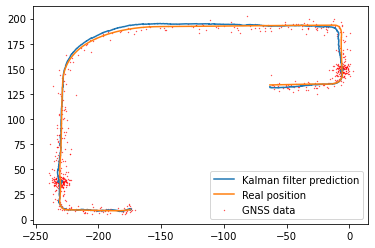

Time : 2218.17 to 2359.24
Time : 2218.17 to 2359.24


In [51]:
print("Position estimate with kalman filter. Samples received : %d of %d"%(len(kal_rvel_list), imu_len))

k_rpos_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_rpos_list])
k_pred_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_obj.states if not x[2]])
k_gnss_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_gnss_list])
k_gact_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_gact_list])

plt.plot(-k_pred_xy[:,0], k_pred_xy[:,1,0], label="Kalman filter prediction")
plt.plot(-k_rpos_xy[:,0], k_rpos_xy[:,1], label="Real position")
plt.scatter(-k_gnss_xy[:,0], k_gnss_xy[:,1], 0.1, label="GNSS data", color='red')
plt.legend()
plt.show()

print("Time : %.2f to %.2f"%(kal_rpos_list[0][1], kal_rpos_list[-1][1]))
print("Time : %.2f to %.2f"%(kal_obj.states[0][1], kal_obj.states[-1][1]))

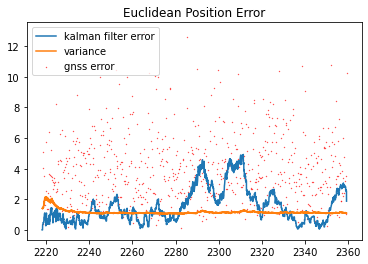

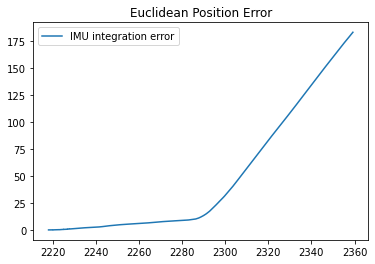

In [53]:
if(len(kal_rpos_list) >= imu_len):
    k_rpos_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_rpos_list])
    k_pred_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_obj.states if not x[2]])
    k_gnss_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_gnss_list])
    k_gact_xy = np.asarray([(x[0][0], x[0][1]) for x in kal_gact_list])
    
    i_rpos_xy = np.asarray([(x[0][0], x[0][1]) for x in int_rpos_list])   
    i_pred_xy = np.asarray([(x[0][0], x[0][1]) for x in int_obj.states])
    
    ierror= np.sqrt(np.sum(np.square(i_rpos_xy-i_pred_xy[:,:,0]),axis=1))
    kerror= np.sqrt(np.sum(np.square(k_rpos_xy-k_pred_xy[:,:,0]),axis=1))
    errorg= np.sqrt(np.sum(np.square(k_gact_xy-k_gnss_xy),axis=1))
    var   = np.sqrt(np.sum([(k[0][0][0], k[0][1][1]) for k in kal_obj.covars], axis=1))

    plt.plot([x[1] for x in kal_rpos_list], kerror, label="kalman filter error")
    plt.plot([x[1] for x in kal_obj.covars], var, label="variance")
    plt.scatter([x[1] for x in kal_gnss_list], errorg, 0.1, label="gnss error", color='red')
    plt.legend()
    plt.title("Euclidean Position Error")
    plt.show()
    
    plt.plot([x[1] for x in int_rpos_list], ierror, label="IMU integration error")
    plt.legend()
    plt.title("Euclidean Position Error")
    plt.show()